#### Откроем и изучим файл

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


##### Разделим фрейм на тренировочную, валидационную и тестовую выборки

In [4]:
df_train1, df_test = train_test_split(df, test_size = 0.2, random_state = 12345)
df_train, df_valid = train_test_split(df_train1, test_size = 0.25, random_state = 12345)

In [5]:
features_train = df_train.drop(['is_ultra'], axis = 1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis = 1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis = 1)
target_test = df_test['is_ultra']

#### Используем несколько моделей и посмотрим, какая лучше себя покажет

##### Решающее дерево. Посмотрим на значение accuracy для max_depth от 1 до 10

In [6]:
scores_tree = []
depths = []

In [7]:
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    score = accuracy_score(target_valid, predictions)
    scores_tree.append(score)
    depths.append(depth)

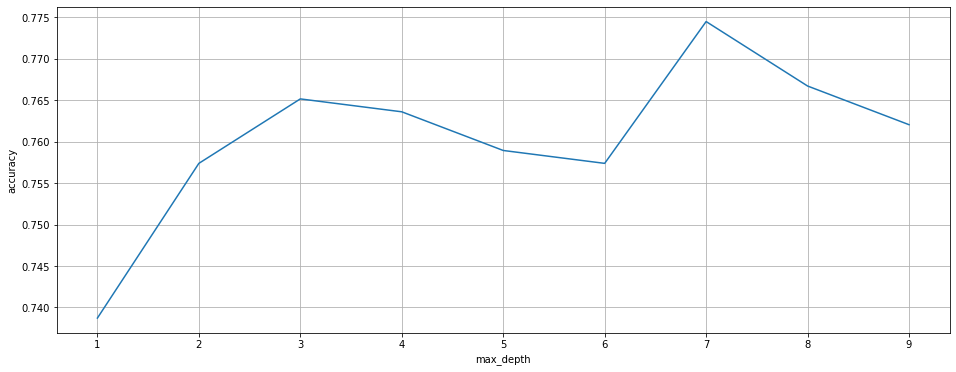

In [8]:
plt.figure(figsize = (16, 6))
plt.plot(depths, scores_tree);
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.grid()

##### Повторим для случайного леса

In [9]:
scores_forest = []
forest_trees = []

In [10]:
for est in range(1, 51, 5):
    model = RandomForestClassifier(random_state = 12345, n_estimators = est)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    score = accuracy_score(target_valid, predictions)
    scores_forest.append(score)
    forest_trees.append(est)

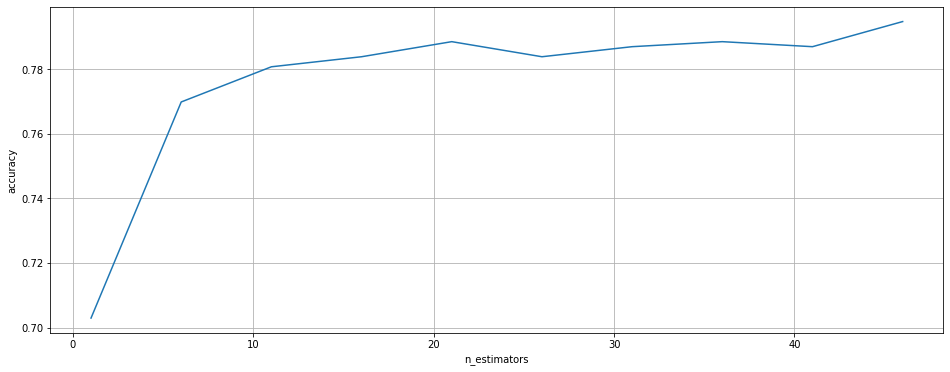

In [11]:
plt.figure(figsize = (16, 6))
plt.plot(forest_trees, scores_forest);
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.grid()

##### Далее посмотрим на модель K ближайших соседей

In [12]:
scores_knn = []
neighbors = []

In [14]:
for n in range(1, 31, 3):
    model = KNeighborsClassifier(n_neighbors = n)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    score = accuracy_score(target_valid, predictions)
    scores_knn.append(score)
    neighbors.append(n)

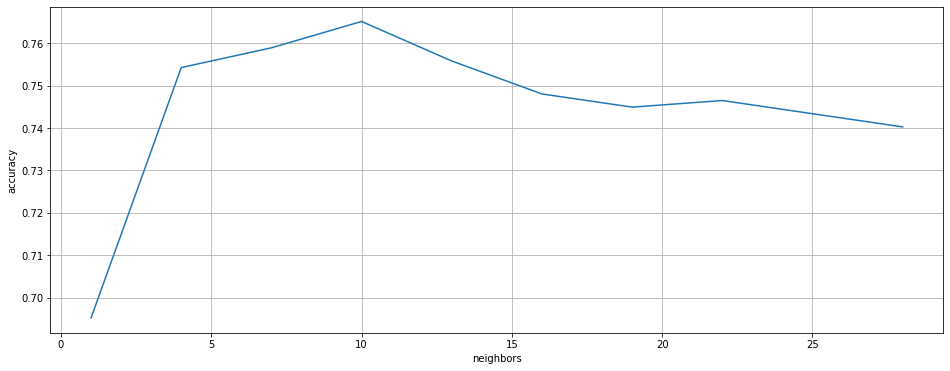

In [15]:
plt.figure(figsize = (16, 6))
plt.plot(neighbors, scores_knn);
plt.xlabel('neighbors')
plt.ylabel('accuracy')
plt.grid()

##### Посмотрим, какая модель показала себя лучше всего

In [21]:
total_scores = scores_tree + scores_forest + scores_knn

In [36]:
print('Наилучший показатель модели решающего дерева:', max(scores_tree))
print('Наилучший показатель модели случайного леса:', max(scores_forest))
print('Наилучший показатель модели ближайших соседей:', max(scores_knn))
print('Итоговый наилучший показатель:', max(total_scores), 'при',
      forest_trees[scores_forest.index(max(scores_forest))], 'деревьях.')

Наилучший показатель модели решающего дерева: 0.7744945567651633
Наилучший показатель модели случайного леса: 0.7947122861586314
Наилучший показатель модели ближайших соседей: 0.7651632970451011
Итоговый наилучший показатель: 0.7947122861586314 при 46 деревьях.


##### Мы проверили 3 модели - решающее дерево, случайный лес и ближайшие соседи. Лучший результат показала модель случайного леса при 46 деревьях

#### Проверим модель на тестовой выборке

In [28]:
model = RandomForestClassifier(random_state = 12345, n_estimators = 46)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
score = accuracy_score(target_test, predictions)
print('Accuracy на тестовой выборке:', score)

Accuracy на тестовой выборке: 0.7900466562986003


#### Проверим модель на адекватность. Посмотрим, сколько людей в нашем фрейме пользуется каким тарифом

In [32]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [35]:
print(df.query('is_ultra == 0')['is_ultra'].count() / df['is_ultra'].count())

0.693528313627878


##### Примерно 69% пользователей пользуются тарифом Смарт. Если бы наша модель всегда предсказывала этот тариф, точность была бы такая же - 69, точность же нашей модели выше - примерно 79%